Libraries we will be using

In [1]:
from scipy.integrate import odeint, trapz
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np

Gravity turn gives us the following ODE:

$\begin{align}
\frac{dv}{dt} &= g(n-sin(\gamma)) \\
\frac{d\gamma}{dt} &= -\frac{1}{v}g\cdot cos(\gamma)
\end{align}$

With $n=\frac{a}{g}$


## Numerical solving

Problem with solving this is that if we start with a vertical rocket at $\gamma=90^{\circ}, v=0 \ m/s$, the set of equations obviously simplify to:

$\begin{align}
\frac{dv}{dt} &= gn \\
\frac{d\gamma}{dt} &= -\infty
\end{align}$

Which of course makes no sense. In practicality what this all means is just that if we don't give the rocket an initial kick, it won't start to fall. 
We could always start with slightly perturbed initial conditions and solve numerically, but as it turns out, the ODE is very stiff and this wont do 
a very good job. What will work instead is starting from a known final angle and velocity, and build our way back to $\gamma=90^{\circ}, v=0 \ m/s$.
This is rather simple and only requires reversing the sign of the ODEs:

$\begin{align}
\frac{dv}{dt} &= -g(n-sin(\gamma)) \\
\frac{d\gamma}{dt} &= \frac{1}{v}g\cdot cos(\gamma)
\end{align}$


In [2]:
def simple_gravityturn(y, t, g, n):
    v, gamma = y
    dvdt = -g*(n-np.sin(gamma))
    dgammadt = g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

## Constant acceleration

Assuming g=9.81, n=3, $\gamma_{final}=20^{\circ}, v_{final}=1,500m/s$

In [3]:
g = 9.81
n = 3
gfinal = np.deg2rad(20)
vfinal = 1500

We will use one pyhtons ODE solvers: odeint

In [4]:
turnsolver = lambda t : odeint(simple_gravityturn, [vfinal, gfinal], [0,t], args=(g,n))[1,:]

If be backwards solve the original ODEs over 10 seconds we get:

In [5]:
turnsolver(10)

array([  1.24221367e+03,   4.15652097e-01])

As expected, the velocity is going down, and so it the angle. But when do we reach zero? Let's use fsolve:

In [6]:
velocity_only = lambda t: turnsolver(t)[0]
t_final = fsolve(velocity_only, 60)

In [7]:
t_final

array([ 63.8765345])

Setting $t_{final}$ to 63.87 seconds we can now get the full trajectory:

In [8]:
t = np.linspace(0, t_final, 1000)
v_simple, gamma_simple = odeint(simple_gravityturn, [vfinal, gfinal], t, args=(g,n)).transpose()

And as requested in the pset, let's plot it:

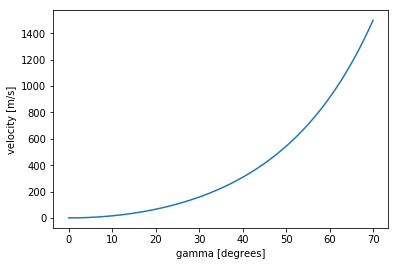

In [9]:
plt.plot(np.rad2deg(np.pi/2-gamma_simple), v_simple);
plt.ylabel('velocity [m/s]')
plt.xlabel('gamma [degrees]')
plt.show()

### Gravity losses

Defined as $\int_{0}^{t_f} g\cdot sin(\gamma)$. We can use the *trapz* function to numerically integrate:

In [10]:
trapz(g*np.sin(gamma_simple), t)

379.88645079909463

## Delta II

### Rocket Thrust and Mass 

From the attached paper on the Delta II we can extract the thrust(in N), assumed at sea level:

In [11]:
Fsolid = 446e3
Fliq = 890e3

From the text we can extract the force profile: 6 boosters and liquid until 63.3s, liquid only for 2.5s, and then liquid and 3 solids until second 129, which as we will see is more than enough to get us to 1500m/s:

In [12]:
F = lambda t: np.piecewise(t, 
                           [(t >= 0) & (t <= 63.3), 
                            (t > 63.3) & (t <= 65.8), 
                            (t > 65.8)], [6*Fsolid+Fliq, Fliq, 3*Fsolid+Fliq])

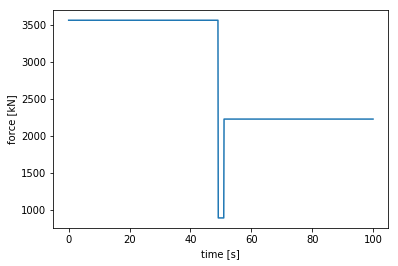

In [13]:
plt.plot(np.linspace(0,100,1000), F(np.linspace(0,129,1000))/1000)
plt.xlabel('time [s]')
plt.ylabel('force [kN]')
plt.show()

And the masses (in kg):

In [14]:
msolid = 13232 
mfuelsolidbooster = 11765
mfuelliq = 96033
msolid_struct = msolid-mfuelsolidbooster
mtotal = 231870 #kg

Which give us a mass profile:

In [15]:
m_solidfuel = lambda t: np.interp(t, np.array([0, 63.3, 65.8, 129]),
                        np.array([0, 
                        6*mfuelsolidbooster, 
                        6*mfuelsolidbooster,
                        9*mfuelsolidbooster]))
m_solid_struct = lambda t: np.piecewise(t, 
                           [(t >= 66) & (t <= 67), 
                            (t > 67) & (t <= 132), 
                            (t > 132)], [3*msolid_struct, 6*msolid_struct, 9*msolid_struct])
m_liqpart = lambda t: np.interp(t, np.array([0, 260.5]), np.array([0, mfuelliq]))
m = lambda t: mtotal-m_solidfuel(t)-m_solid_struct(t)-m_liqpart(t)

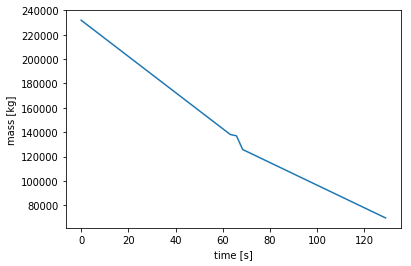

In [16]:
plt.plot(np.linspace(0,129), m(np.linspace(0,129)));
plt.xlabel('time [s]')
plt.ylabel('mass [kg]')
plt.show()

### ODE solving

In [17]:
def delta_gravityturn(y, t, g, F, m, tf):
    v, gamma = y
    dvdt = -F(tf-t)/m(tf-t)+g*np.sin(gamma)
    dgammadt = g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

In [18]:
deltaturnsolver = lambda t : odeint(delta_gravityturn, [vfinal, gfinal], [0,t], args=(g,F,m,t))[1,:]

In [19]:
delta_velocity_only = lambda t: deltaturnsolver(t)[0]
t_zero_delta = fsolve(delta_velocity_only, 60)

In [20]:
t_zero_delta

array([ 115.07624814])

Let's verify that final velocity and angle are indeed 0 and $\pi$:

In [21]:
deltaturnsolver(t_zero_delta)

array([ -1.39710479e-06,   1.57079633e+00])

In [22]:
t = np.linspace(0, t_zero_delta, 1000)
yout = odeint(delta_gravityturn, [vfinal, gfinal], t, args=(g,F,m,t_zero_delta))
v_delta,gamma_delta = yout.transpose()

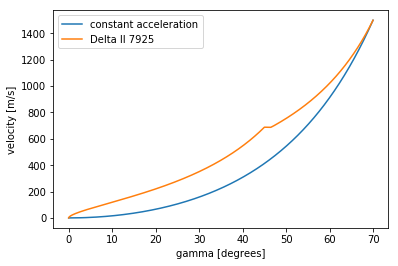

In [23]:
plt.plot(np.rad2deg(np.pi/2-gamma_simple), v_simple);
plt.plot(np.rad2deg(np.pi/2-gamma_delta), v_delta);
plt.ylabel('velocity [m/s]')
plt.xlabel('gamma [degrees]')
plt.legend(['constant acceleration','Delta II 7925'])
plt.show()

### Gravity losses
Defined as $\int_{0}^{t_f} g\cdot sin(\gamma)$

In [24]:
trapz(g*np.sin(gamma_delta), t)

822.08631999177169

Hence we find $\Delta v_{g} = 822 m/s$

## Drag

To account for drag we will need to add a model of the atmosphere which we will assume isothermal, aka:

$ \rho = \rho_0 e^{\frac{-z}{H}}$

With $\rho_0 = 1.225 kg/m^{3}$ and $H=\frac{RT}{g}$

In [25]:
R = 287
T = 290
H = R*T/g
rho0 = 1.225

And drag specific constants:

In [26]:
CD = 0.2
area = lambda D: np.pi*(D/2)**2
D_base = 2.438
D_wide = 2.896

Area for drag being average cross section areas

In [27]:
A_base = area(D_base)
A_wide = area(D_wide)

In [28]:
A = 0.5*(A_wide+A_base)

### ODE formulation

This time we need to add altitude as a variable to our ode, as we need to calculate the density with altitude:

In [29]:
def drag_gravityturn(y, t, g, F, m, tf):
    v, gamma, z = y
    rho = rho0*np.exp(-z/H)
    dvdt = -F(tf-t)/m(tf-t)+g*np.sin(gamma)+0.5*CD*A*rho*v**2/m(tf-t)
    dgammadt = g*np.cos(gamma)/v
    dzdt = -v*np.sin(gamma)
    dydt = [dvdt, dgammadt, dzdt]
    return dydt

In [30]:
dragsolver = lambda t, z: odeint(drag_gravityturn, [vfinal, gfinal, z], [0,t], args=(g,F,m,t))[1,:]

To find the initial conditions we don't only need to find the right final time, but also the right final altitude:

In [38]:
z_final_guess = 60000
t_final_guess = 50
velocity_only = lambda x: dragsolver(x[0], x[1])[[0,2]]
t_final_drag, z_final_drag = fsolve(velocity_only, np.array([t_final_guess, z_final_guess]))

Let's just verify that the time and altitude do converge to zero:

In [39]:
velocity_only((t_final_drag, z_final_drag))

array([ -7.98881116e-06,   3.23405707e-04])

And let's also verify that we haven't gone beyond the 129 seconds at which point we would have to expand or mass model:

In [32]:
t_final_drag, z_final_drag

(116.43188361360917, 41080.76908775905)

Phew, we are all good! We can now get all our variables of interest:

In [33]:
t = np.linspace(0, t_final_drag, 1000)
v_drag,gamma_drag,z = odeint(drag_gravityturn, 
                             [vfinal, gfinal, z_final_drag], t, args=(g,F,m,t_final_drag)).transpose()

### Gravity losses

Defined as $\int_{0}^{t_f} \frac{0.5 C_D A\rho v^{2}}{M}$

In [34]:
rho = rho0*np.exp(-z/H)

In [35]:
trapz(0.5*CD*A*rho*v_drag**2/m(t), t)

22.287838460335081

Hence we find $\Delta v_{drag} = 22.28 m/s$

### Gravity losses

Just for fun:

In [36]:
trapz(g*np.sin(gamma_drag), t)

834.61650523061826

Hence we find that when we include drag $\Delta v_{g} = 834.6 m/s$.

And to wrap it all up let's just compare all the models:

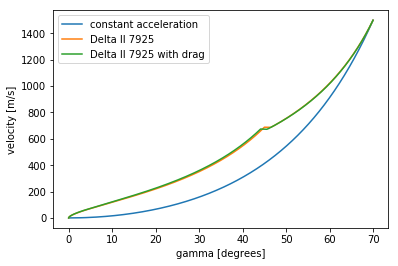

In [37]:
plt.plot(np.rad2deg(np.pi/2-gamma_simple), v_simple);
plt.plot(np.rad2deg(np.pi/2-gamma_delta), v_delta);
plt.plot(np.rad2deg(np.pi/2-gamma_drag), v_drag);
plt.ylabel('velocity [m/s]')
plt.xlabel('gamma [degrees]')
plt.legend(['constant acceleration','Delta II 7925', 'Delta II 7925 with drag']);
plt.show()